In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from numba.typed import List
from tqdm.auto import tqdm

from src.constant import LABELS
from src.data_util import preload_cqf, preload_eegs, train_valid_split
from src.dataset.eeg import PerEegSubsampleDataset, get_train_loader, PerEegDataset
from src.model.feature_extractor.wave2spec import Wave2Spectrogram
from src.preprocess import (
    process_label,
)
from src.proc_util import trace

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
print(list(data_dir.glob("*")))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata.sample(10)

[PosixPath('../../../input/hms-harmful-brain-activity-classification/test_eegs'), PosixPath('../../../input/hms-harmful-brain-activity-classification/single'), PosixPath('../../../input/hms-harmful-brain-activity-classification/test.csv'), PosixPath('../../../input/hms-harmful-brain-activity-classification/example_figures'), PosixPath('../../../input/hms-harmful-brain-activity-classification/test_spectrograms'), PosixPath('../../../input/hms-harmful-brain-activity-classification/train_spectrograms'), PosixPath('../../../input/hms-harmful-brain-activity-classification/sample_submission.csv'), PosixPath('../../../input/hms-harmful-brain-activity-classification/train_eegs'), PosixPath('../../../input/hms-harmful-brain-activity-classification/train.csv')]


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,seizure_vote_per_eeg,lpd_vote_per_eeg,gpd_vote_per_eeg,lrda_vote_per_eeg,grda_vote_per_eeg,other_vote_per_eeg,label_count_per_eeg,total_votes_per_eeg,weight,weight_per_eeg,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,seizure_prob_per_eeg,lpd_prob_per_eeg,gpd_prob_per_eeg,lrda_prob_per_eeg,grda_prob_per_eeg,other_prob_per_eeg,num_unique_vote_combinations_per_eeg,duration_sec,duration_min,num_labels_per_eeg,num_unique_vote_combinations_per_label,num_labels_per_duration_sec,num_unique_vote_combinations_per_duration_sec,min_eeg_label_offset_sec,max_eeg_label_offset_sec
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,u32,f64,f64,f64,f64,f64
3338045490,24,102.0,118150401,24,102.0,243282550,6475,"""Seizure""",3,0,0,0,0,0,3,3.0,0.0,14.4,0.0,0.0,0.0,25,17.4,0.339244,0.984224,1.0,0.0,0.0,0.0,0.0,0.0,0.172414,0.0,0.827586,0.0,0.0,0.0,2,152.0,2.533333,25,0.08,0.164474,0.013158,0.0,102.0
3318431062,2,8.0,1852640677,2,8.0,1557080764,8869,"""GRDA""",0,0,0,0,3,0,3,0.0,0.0,0.0,0.0,3.0,0.0,5,3.0,0.339244,0.339244,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,66.0,1.1,5,0.2,0.075758,0.015152,0.0,16.0
318072944,16,64.0,1863712617,310,6816.0,182327581,35225,"""LRDA""",1,3,0,5,0,3,12,0.474576,4.220339,0.0,2.627119,0.0,2.40678,59,9.728814,0.9116,0.828676,0.083333,0.25,0.0,0.416667,0.0,0.25,0.04878,0.433798,0.0,0.270035,0.0,0.247387,4,480.0,8.0,59,0.067797,0.122917,0.008333,0.0,430.0
1378468467,89,788.0,1254544437,295,4489.0,1086010864,36297,"""Other""",2,0,0,2,0,9,13,0.428571,1.736264,0.0,0.472527,0.252747,2.835165,91,5.725275,0.935031,0.560147,0.153846,0.0,0.0,0.153846,0.0,0.692308,0.074856,0.303263,0.0,0.082534,0.044146,0.495202,17,842.0,14.033333,91,0.186813,0.108076,0.02019,0.0,792.0
3698252652,106,546.0,741558530,106,546.0,3095565687,5545,"""GRDA""",0,0,0,0,3,0,3,0.0,0.0,0.0,0.0,3.0,0.0,135,3.0,0.339244,0.339244,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,732.0,12.2,135,0.007407,0.184426,0.001366,0.0,682.0
2860052642,215,924.0,840003147,215,924.0,3098173030,2641,"""GPD""",1,0,2,0,0,0,3,0.850187,0.0,2.149813,0.0,0.0,0.0,534,3.0,0.339244,0.339244,0.333333,0.0,0.666667,0.0,0.0,0.0,0.283396,0.0,0.716604,0.0,0.0,0.0,2,2384.0,39.733333,534,0.003745,0.223993,0.000839,0.0,2334.0
2699430130,1,8.0,930125532,1,8.0,591891401,23942,"""Other""",0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,0.0,3.0,2,3.0,0.339244,0.339244,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,58.0,0.966667,2,0.5,0.034483,0.017241,0.0,8.0
2047180059,1,2.0,1683218795,1,2.0,672503585,51024,"""GPD""",2,0,12,0,0,1,15,2.0,0.0,12.0,0.0,0.0,1.0,2,15.0,0.965555,0.965555,0.133333,0.0,0.8,0.0,0.0,0.066667,0.133333,0.0,0.8,0.0,0.0,0.066667,1,52.0,0.866667,2,0.5,0.038462,0.019231,0.0,2.0
1351916101,6,22.0,1070726094,6,22.0,964526477,19311,"""LPD""",0,12,0,0,0,0,12,0.0,12.0,0.0,0.0,0.0,0.0,7,12.0,0.9116,0.9116,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,72.0,1.2,7,0.142857,0.097222,0.013889,0.0,22.0


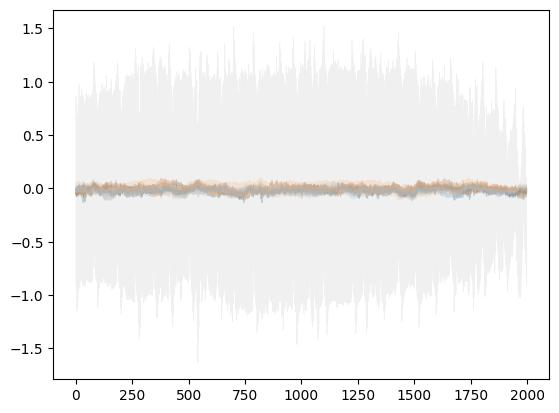

In [3]:
preprocess_dir = Path("../data/preprocess/train")

sample_dir = preprocess_dir / "1000913311"
eeg = np.load(sample_dir / "eeg.npy")
eeg.shape
plt.plot(eeg, lw=0.5, alpha=0.3)
plt.show()

In [4]:
fold = 0
fold_dir = Path("../data/fold_split/train")
fold_split_df = pl.read_parquet(fold_dir / "fold_split.pqt")
train_df, valid_df = train_valid_split(metadata, fold_split_df, fold=fold)
train_df.shape, valid_df.shape

((84696, 47), (22104, 47))

In [5]:
with trace("load eeg"):
    eeg_ids = fold_split_df["eeg_id"].unique().to_list()
    id2eeg = preload_eegs(eeg_ids, preprocess_dir)
    id2cqf = preload_cqf(eeg_ids, preprocess_dir)

  0%|          | 0/17089 [00:00<?, ?it/s]

100%|██████████| 17089/17089 [00:02<00:00, 7340.38it/s]
[4.6GB(+4.0GB):4.7sec] load eeg 


In [61]:
hop_length = 64
train_df = metadata.filter(
    pl.col("eeg_id").is_in([1626483520, 1159334316, 1594739602, 2110164906])
)

train_dataset = PerEegSubsampleDataset(
    train_df, id2eeg, id2cqf=id2cqf, num_samples_per_eeg=1
)
train_loader = get_train_loader(
    train_dataset,
    batch_size=4,
    num_workers=1,
    pin_memory=False,
    persistent_workers=True,
)
valid_dataset = PerEegDataset(valid_df, id2eeg, id2cqf=id2cqf)
valid_loader = get_train_loader(
    valid_dataset,
    batch_size=1,
    num_workers=1,
    pin_memory=False,
    persistent_workers=True,
)
model = Wave2Spectrogram(
    hop_length=hop_length,
    cutoff_freqs=(0.5, 50),
    apply_mask=False,
    downsample_mode="linear",
)
device = torch.device("cuda")
model.to(device)
threshold = 0.5

for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
    eeg, eeg_id, label, weight, cqf = (
        batch["eeg"],
        batch["eeg_id"],
        batch["label"],
        batch["weight"],
        batch["cqf"],
    )
    eeg = eeg.to(device)
    cqf = cqf.to(device)
    # mask = (cqf > threshold).to(torch.float32)
    # mask = mask.to(device)
    # output = model(eeg, mask=mask, apply_mask=True)
    output = model(eeg, mask=cqf)
    spectrogram = output["spectrogram"].detach().cpu().numpy()
    signal = output["signal"].detach().cpu().numpy()
    channel_mask = output["channel_mask"].detach().cpu().numpy()
    spec_mask = output["spec_mask"].detach().cpu().numpy()
    probe_pairs = output["probe_pairs"]
    probe_groups = output["probe_groups"]
    eeg_id = eeg_id.detach().cpu().numpy()

    num_batches = spectrogram.shape[0]
    break

  0%|          | 0/1 [00:00<?, ?it/s]

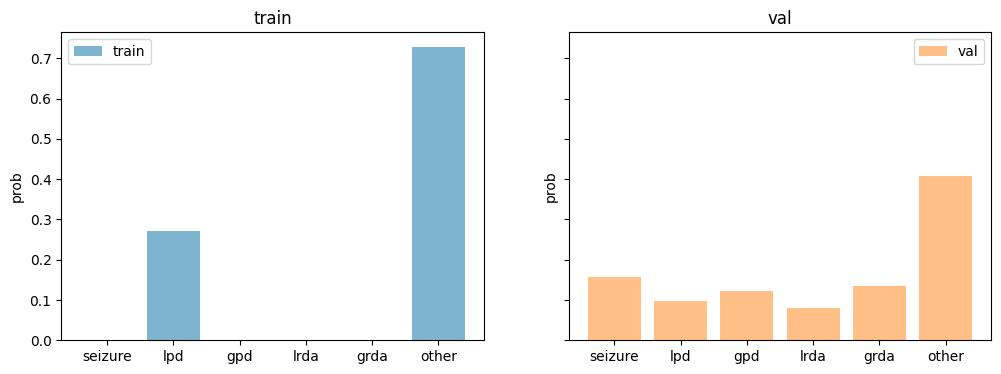

In [62]:
val_eeg = (
    valid_df.group_by("eeg_id")
    .agg(pl.col(f"{label}_vote").mean() for label in LABELS)
    .drop("eeg_id")
    .to_numpy()
)
train_eeg = (
    train_df.group_by("eeg_id")
    .agg(pl.col(f"{label}_vote").mean() for label in LABELS)
    .drop("eeg_id")
    .to_numpy()
)
val_eeg = val_eeg / val_eeg.sum(axis=1, keepdims=True)
train_eeg = train_eeg / train_eeg.sum(axis=1, keepdims=True)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax1.bar(LABELS, train_eeg.mean(axis=0), alpha=0.5, label="train", color="C0")
ax2.bar(LABELS, val_eeg.mean(axis=0), alpha=0.5, label="val", color="C1")
ax1.set(title="train", ylabel="prob")
ax2.set(title="val", ylabel="prob")
ax1.legend()
ax2.legend()

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from src.visualization import format_time, mean_normalization
from src.plot_util import shift_plot


def plot_signal(
    signal: List[List[np.float32]],
    probe_pairs: list[tuple["str", "str"]],
    probe_groups: list["str"],
    sampling_rate: float = 40,
    shift: float = 0.5,
    lw=0.8,
    ax=None,
    figsize=(8, 6),
    fill_area=False,
):
    """
    signal: (probe, frame)
    """

    def plot_probe_pair(
        signal, time, probe_pairs, probe_groups, ax, offset=0, names=[]
    ):
        pg2color = dict(LL="C0", LP="C0", Z="C2", RP="C1", RL="C1")
        for (p1, p2), probe_group, sig in zip(probe_pairs, probe_groups, signal):
            name = f"{p1}-{p2}" if p2 is not None else p1
            ax.plot(
                time,
                sig + offset,
                label=f"{p1}-{p2}",
                color=pg2color[probe_group],
                lw=lw,
            )
            if fill_area:
                ax.fill_between(
                    time,
                    offset,
                    sig + offset,
                    color=pg2color[probe_group],
                    alpha=0.5,
                )
            offset -= shift
            names.append(name)
        return offset, names

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    names = []
    offset_y = 0

    total_sec = signal.shape[-1] / sampling_rate

    num_samples = signal.shape[-1]
    time = np.linspace(0, total_sec, num_samples)

    offset_y, names = plot_probe_pair(
        signal, time, probe_pairs, probe_groups, ax, offset_y, names
    )
    num_ticks = len(names)
    yticks = np.linspace(0, offset_y, num_ticks, endpoint=False)
    ax.set_yticks(ticks=yticks, labels=names)
    ax.set_ylim(offset_y, shift)

    formatter = ticker.FuncFormatter(format_time)
    ax.xaxis.set_major_formatter(formatter)

1626483520
seizure=0.00, lpd=0.09, gpd=0.00, lrda=0.00, grda=0.00, other=0.91
k 0
spectrogram (18, 128, 32)
signal (18, 2048)
chnanel_mask (18, 2048)
spec_mask (18, 1, 32)
weight 23.0


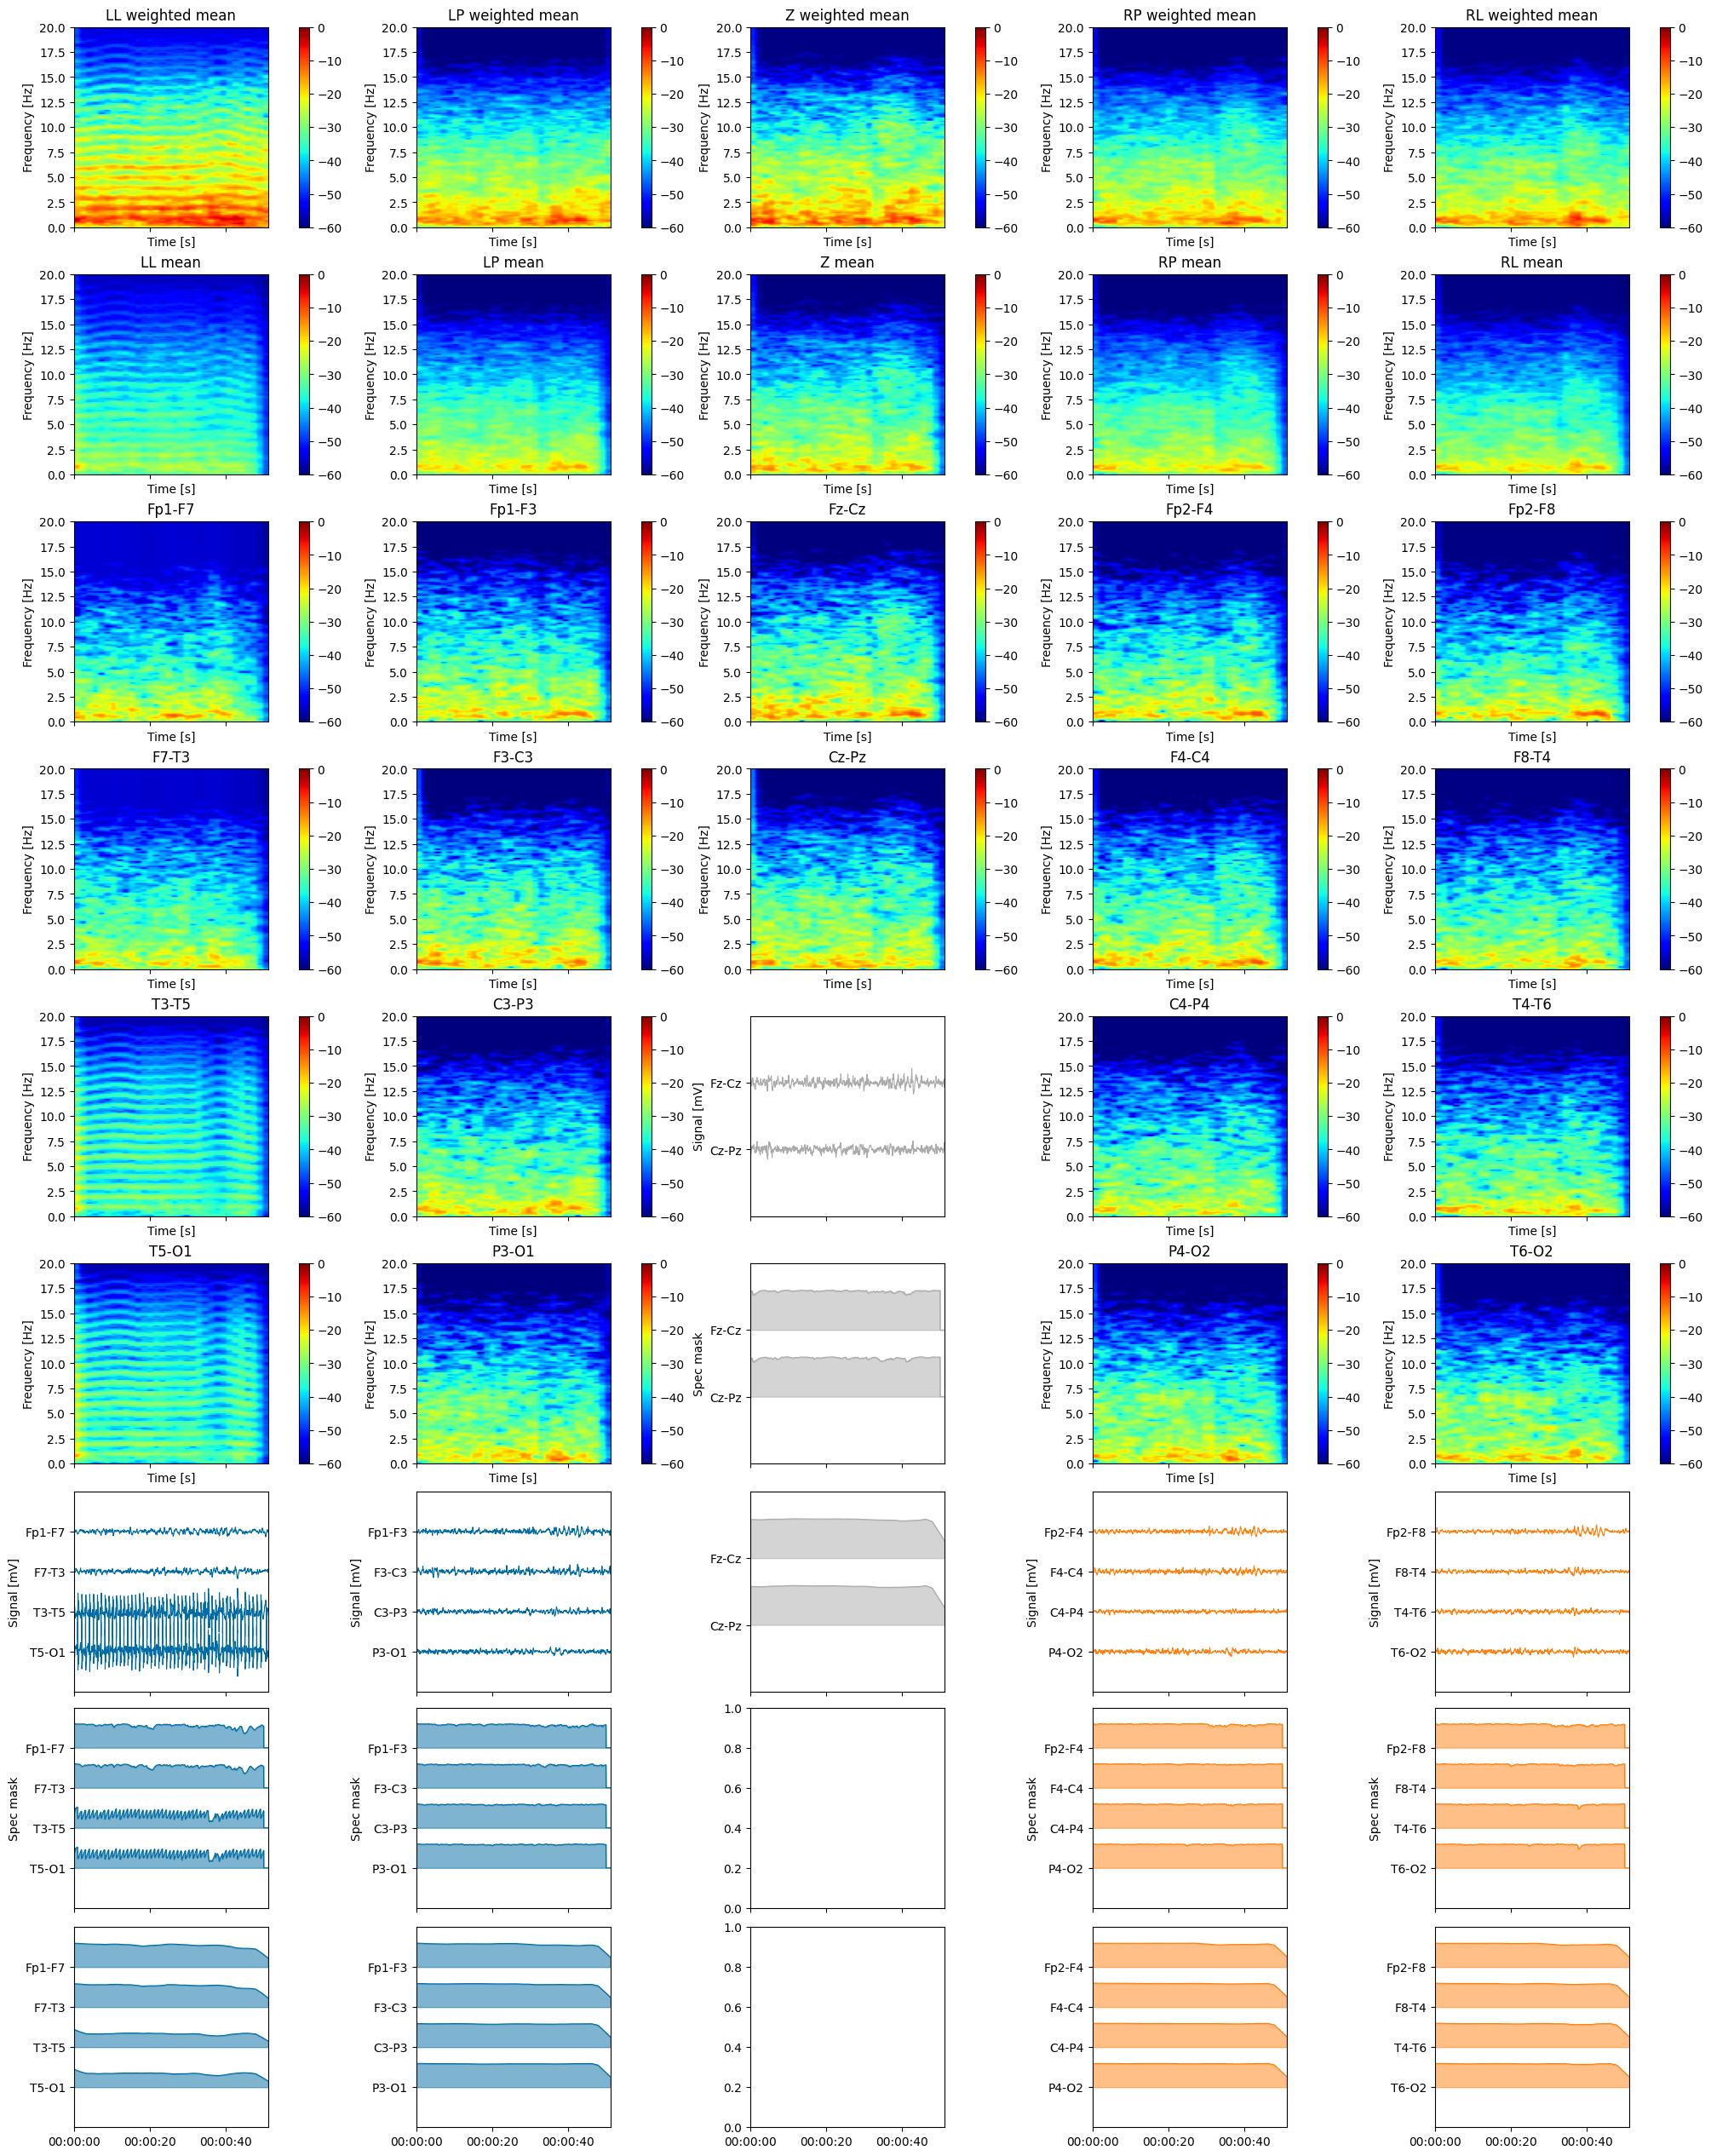

1159334316
seizure=0.00, lpd=0.00, gpd=0.00, lrda=0.00, grda=0.00, other=1.00
k 1
spectrogram (18, 128, 32)
signal (18, 2048)
chnanel_mask (18, 2048)
spec_mask (18, 1, 32)
weight 12.0


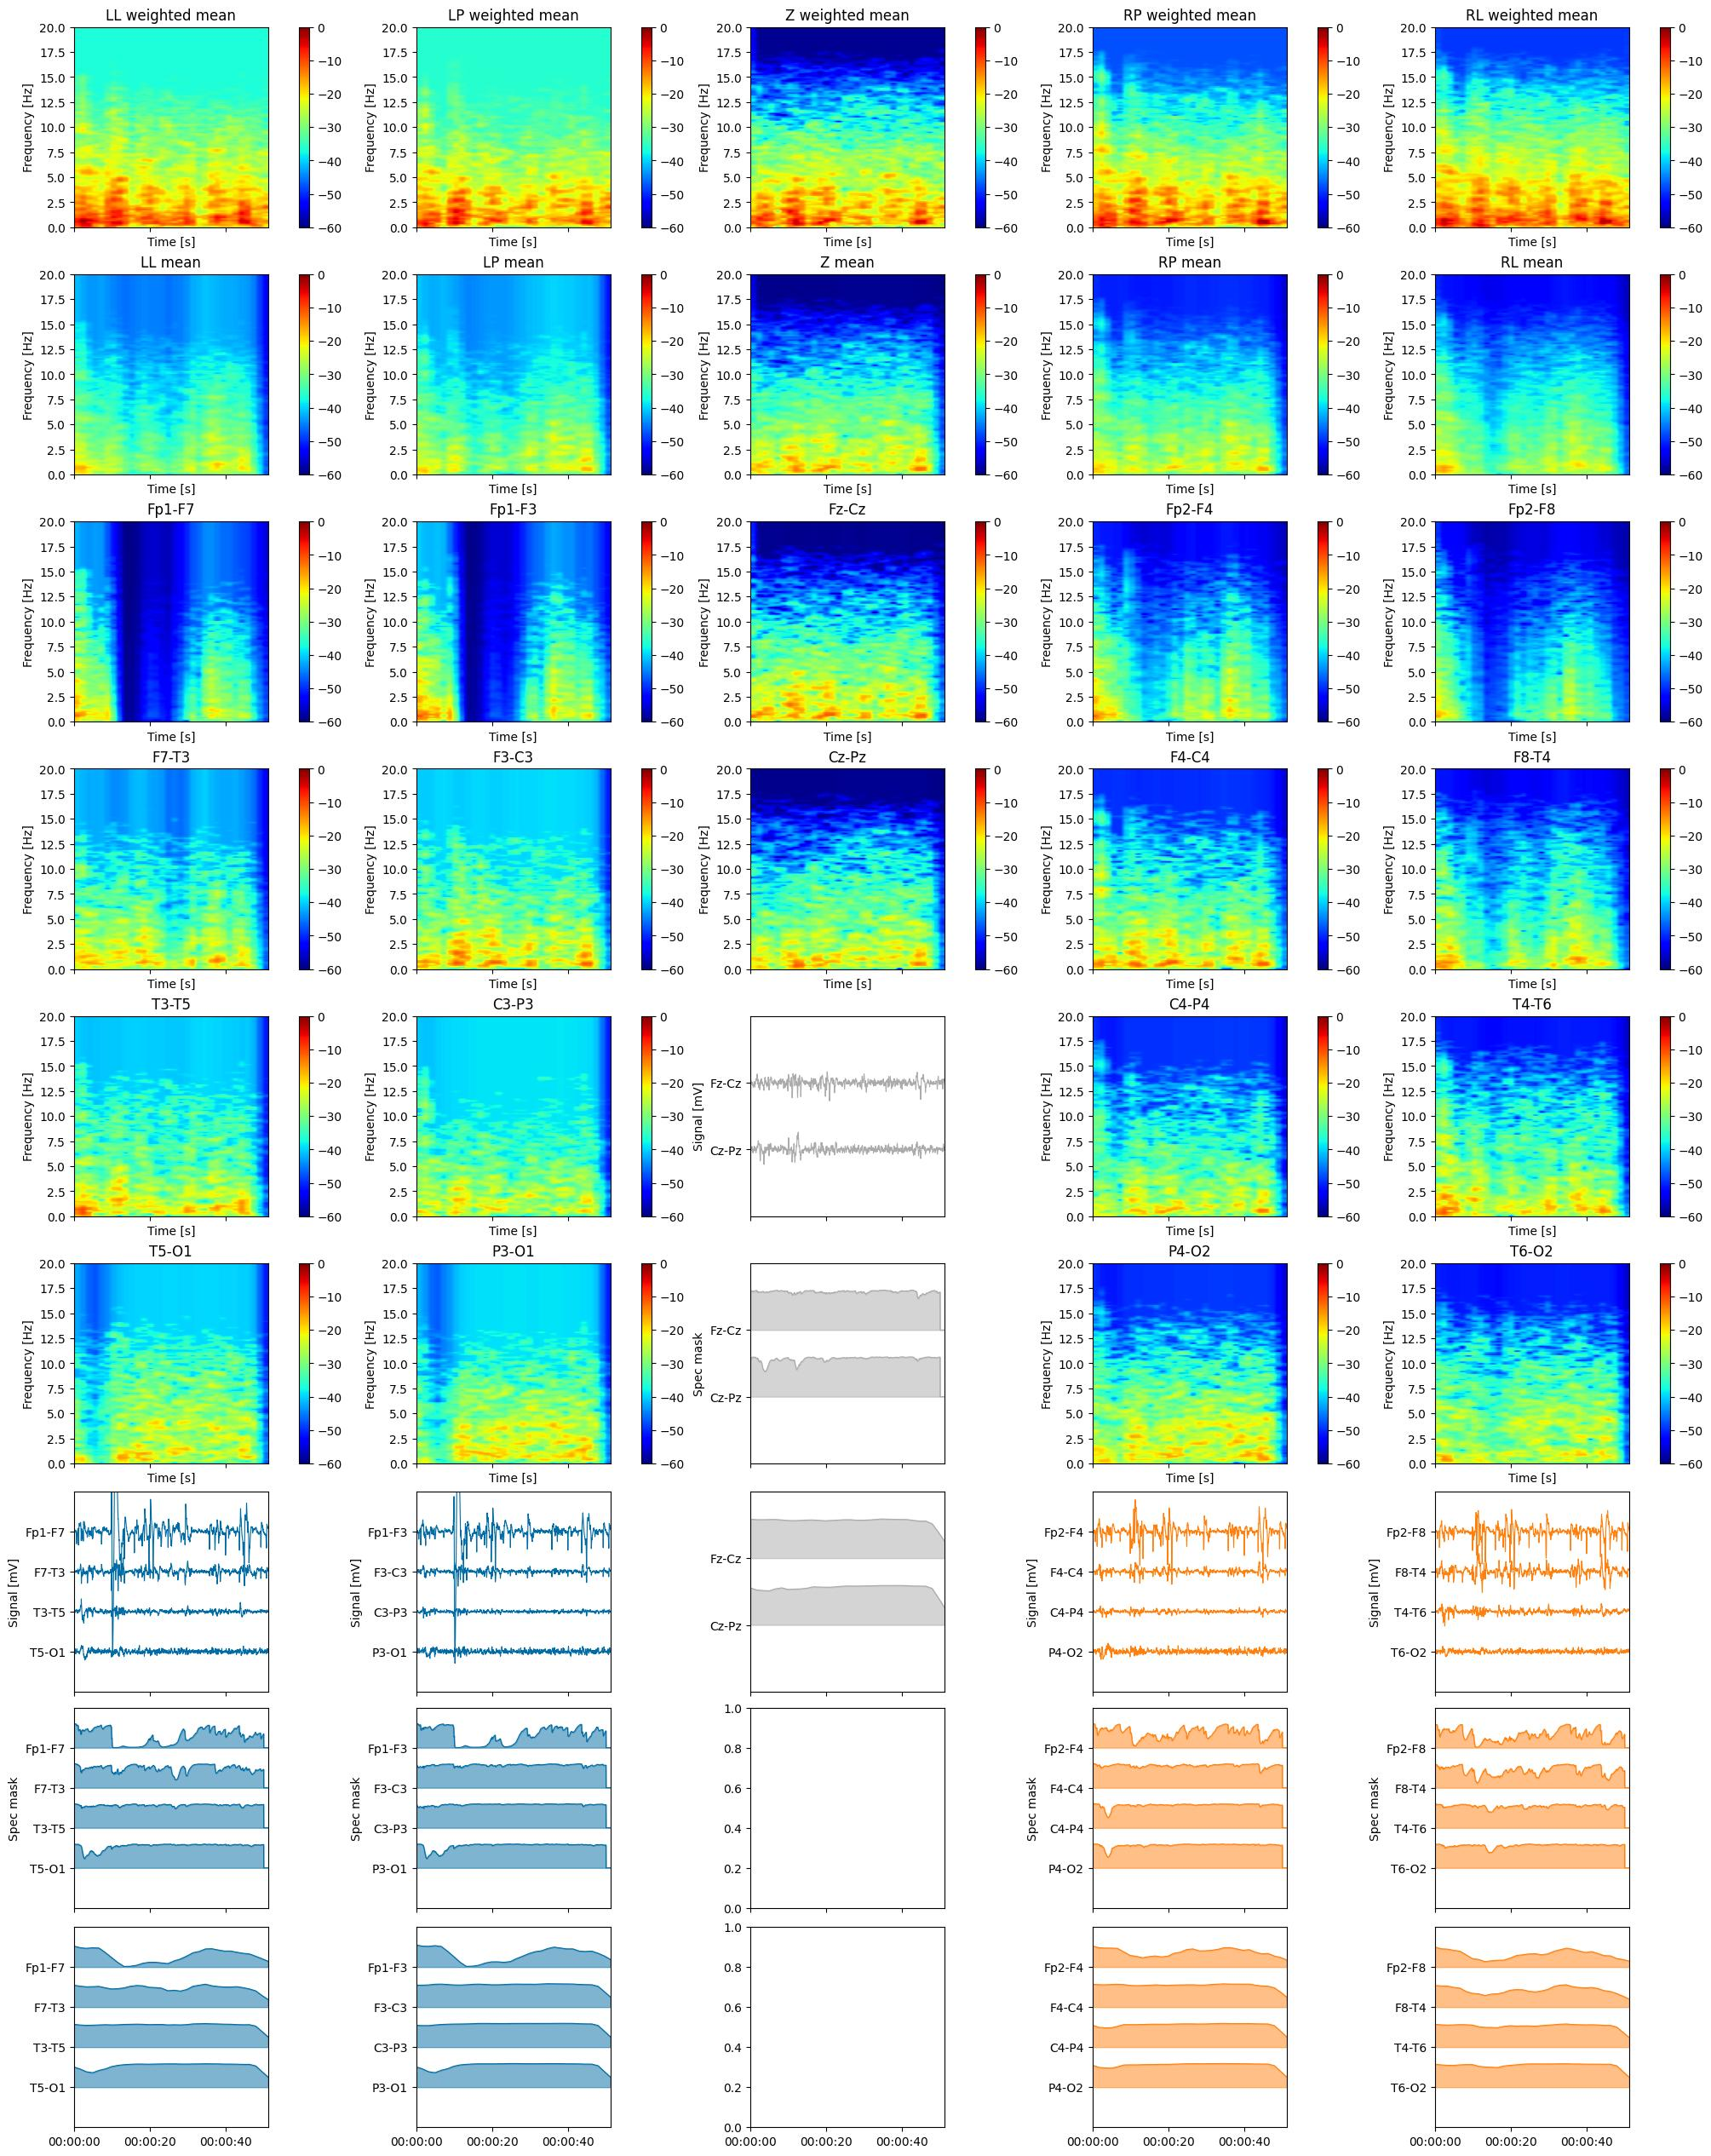

2110164906
seizure=0.00, lpd=1.00, gpd=0.00, lrda=0.00, grda=0.00, other=0.00
k 2
spectrogram (18, 128, 32)
signal (18, 2048)
chnanel_mask (18, 2048)
spec_mask (18, 1, 32)
weight 14.0


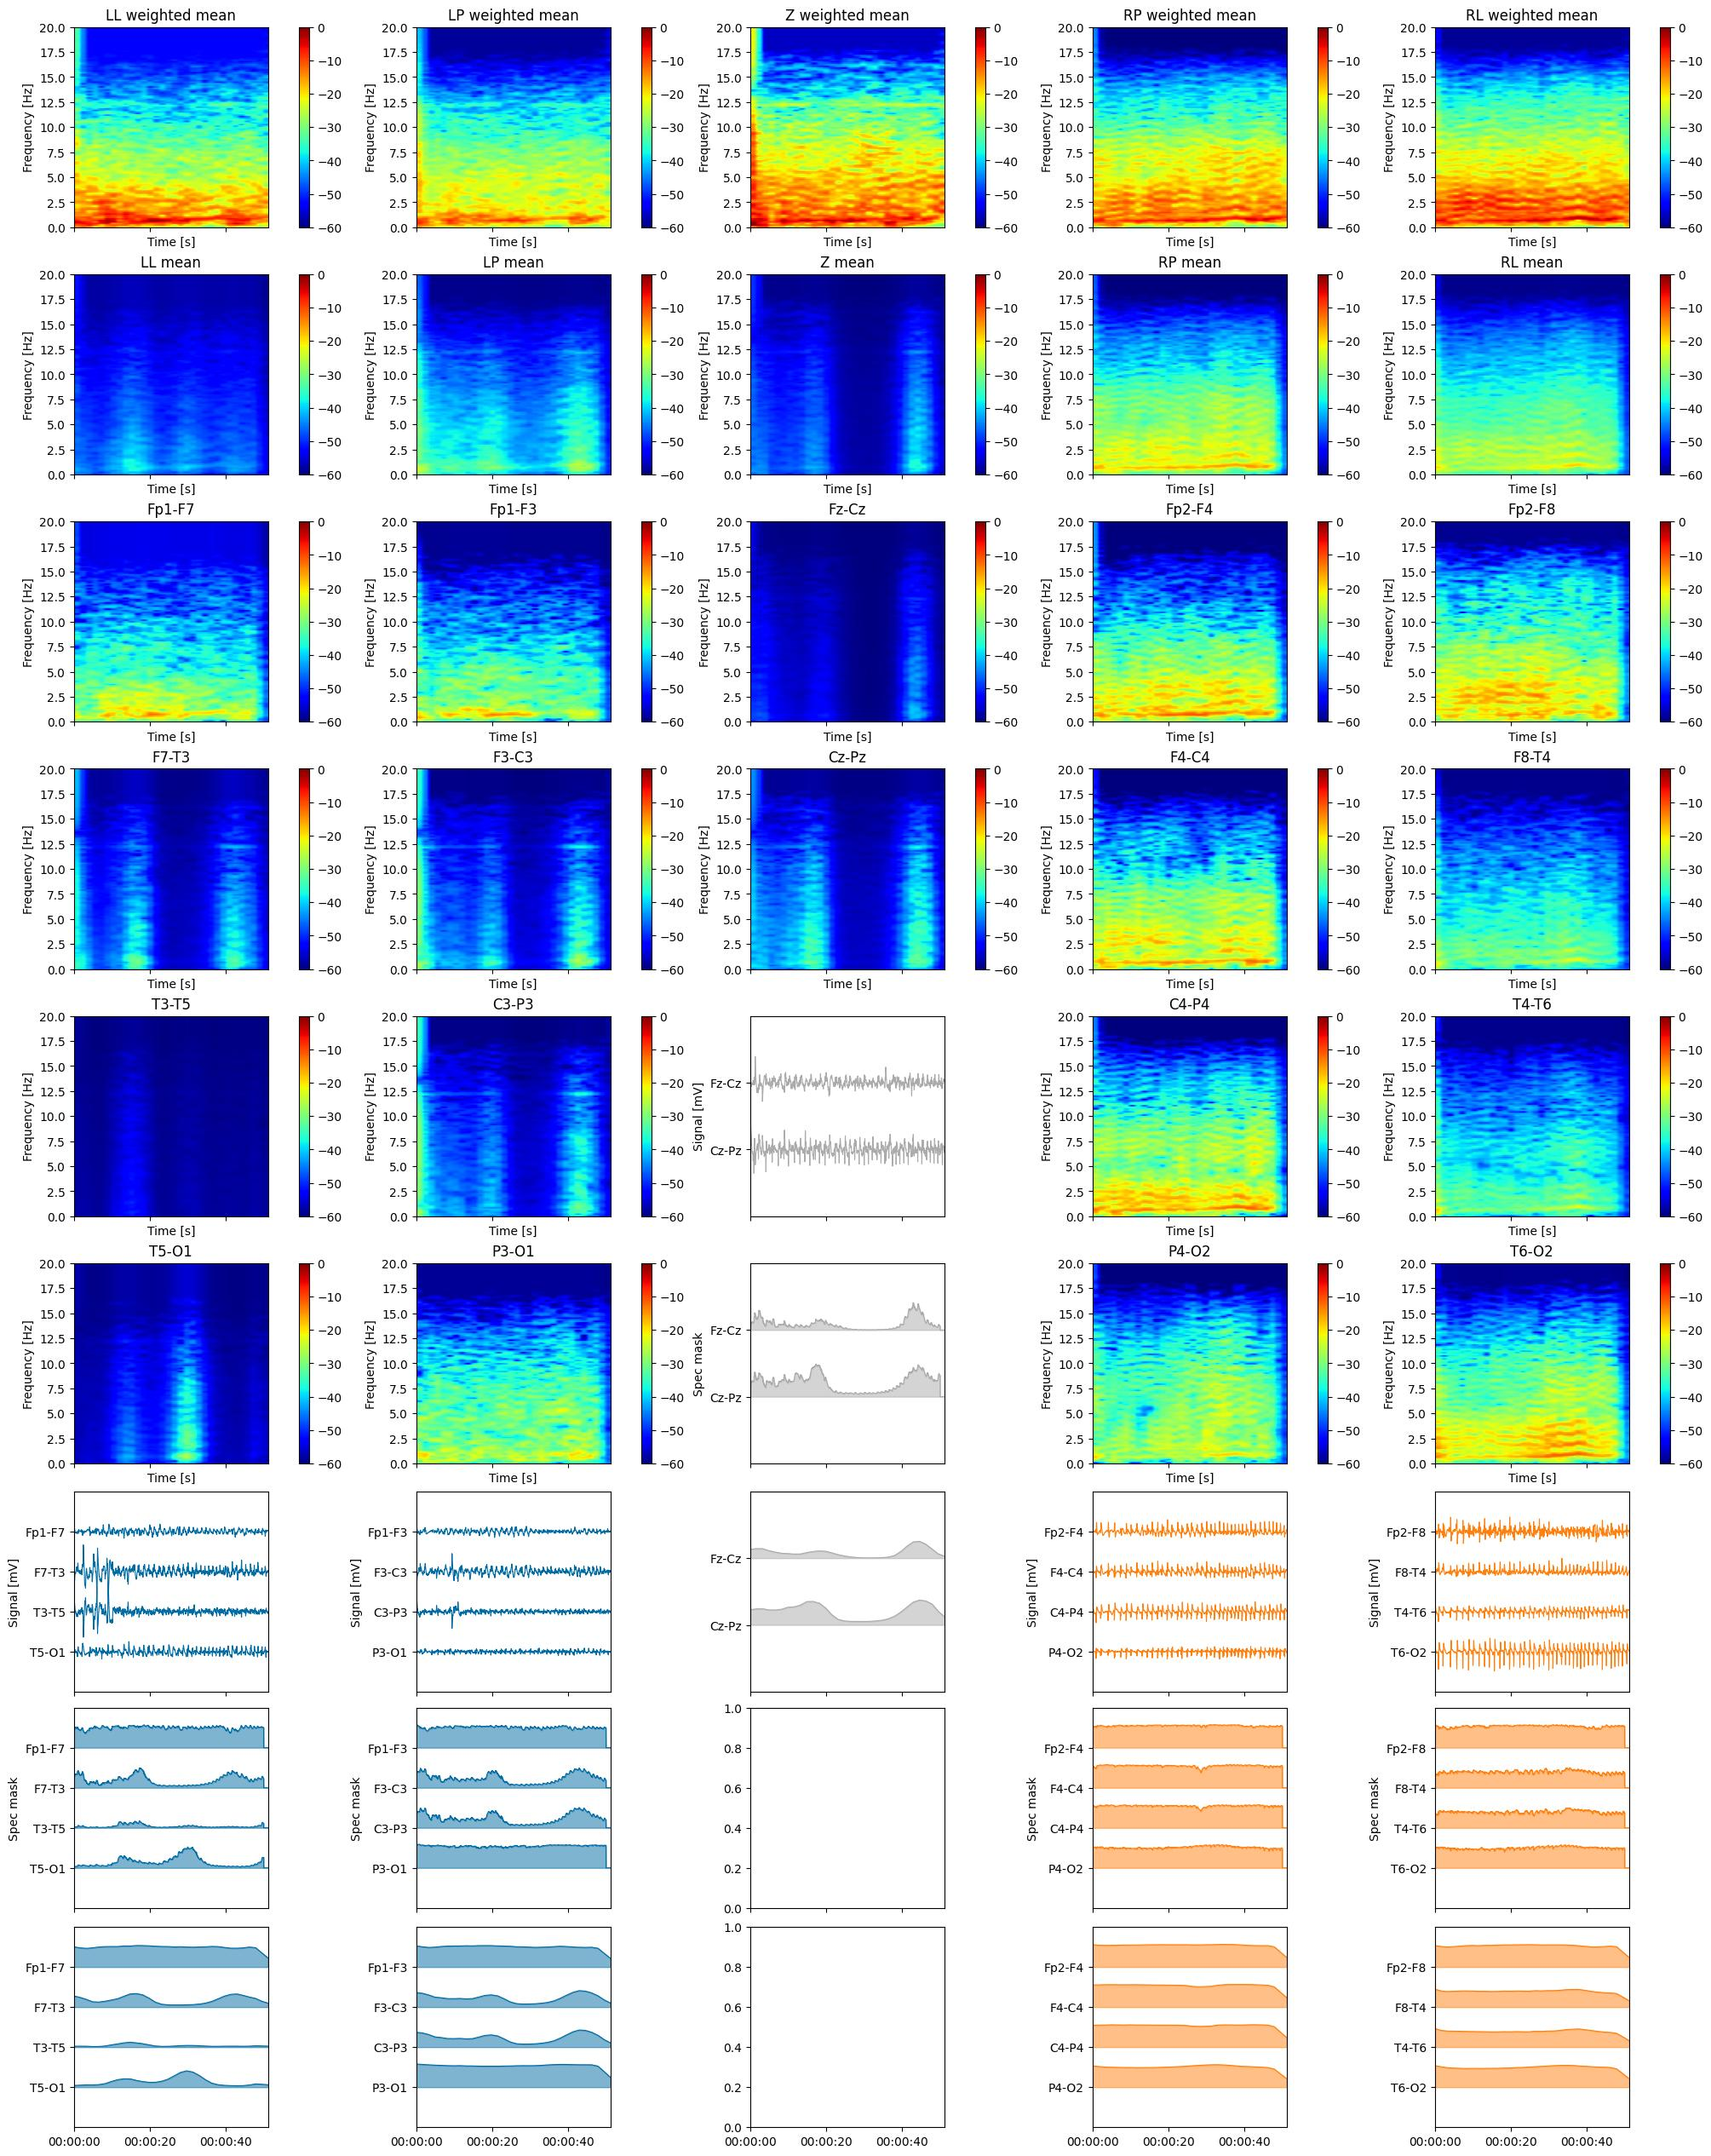

1594739602
seizure=0.00, lpd=0.00, gpd=0.00, lrda=0.00, grda=0.00, other=1.00
k 3
spectrogram (18, 128, 32)
signal (18, 2048)
chnanel_mask (18, 2048)
spec_mask (18, 1, 32)
weight 2.0


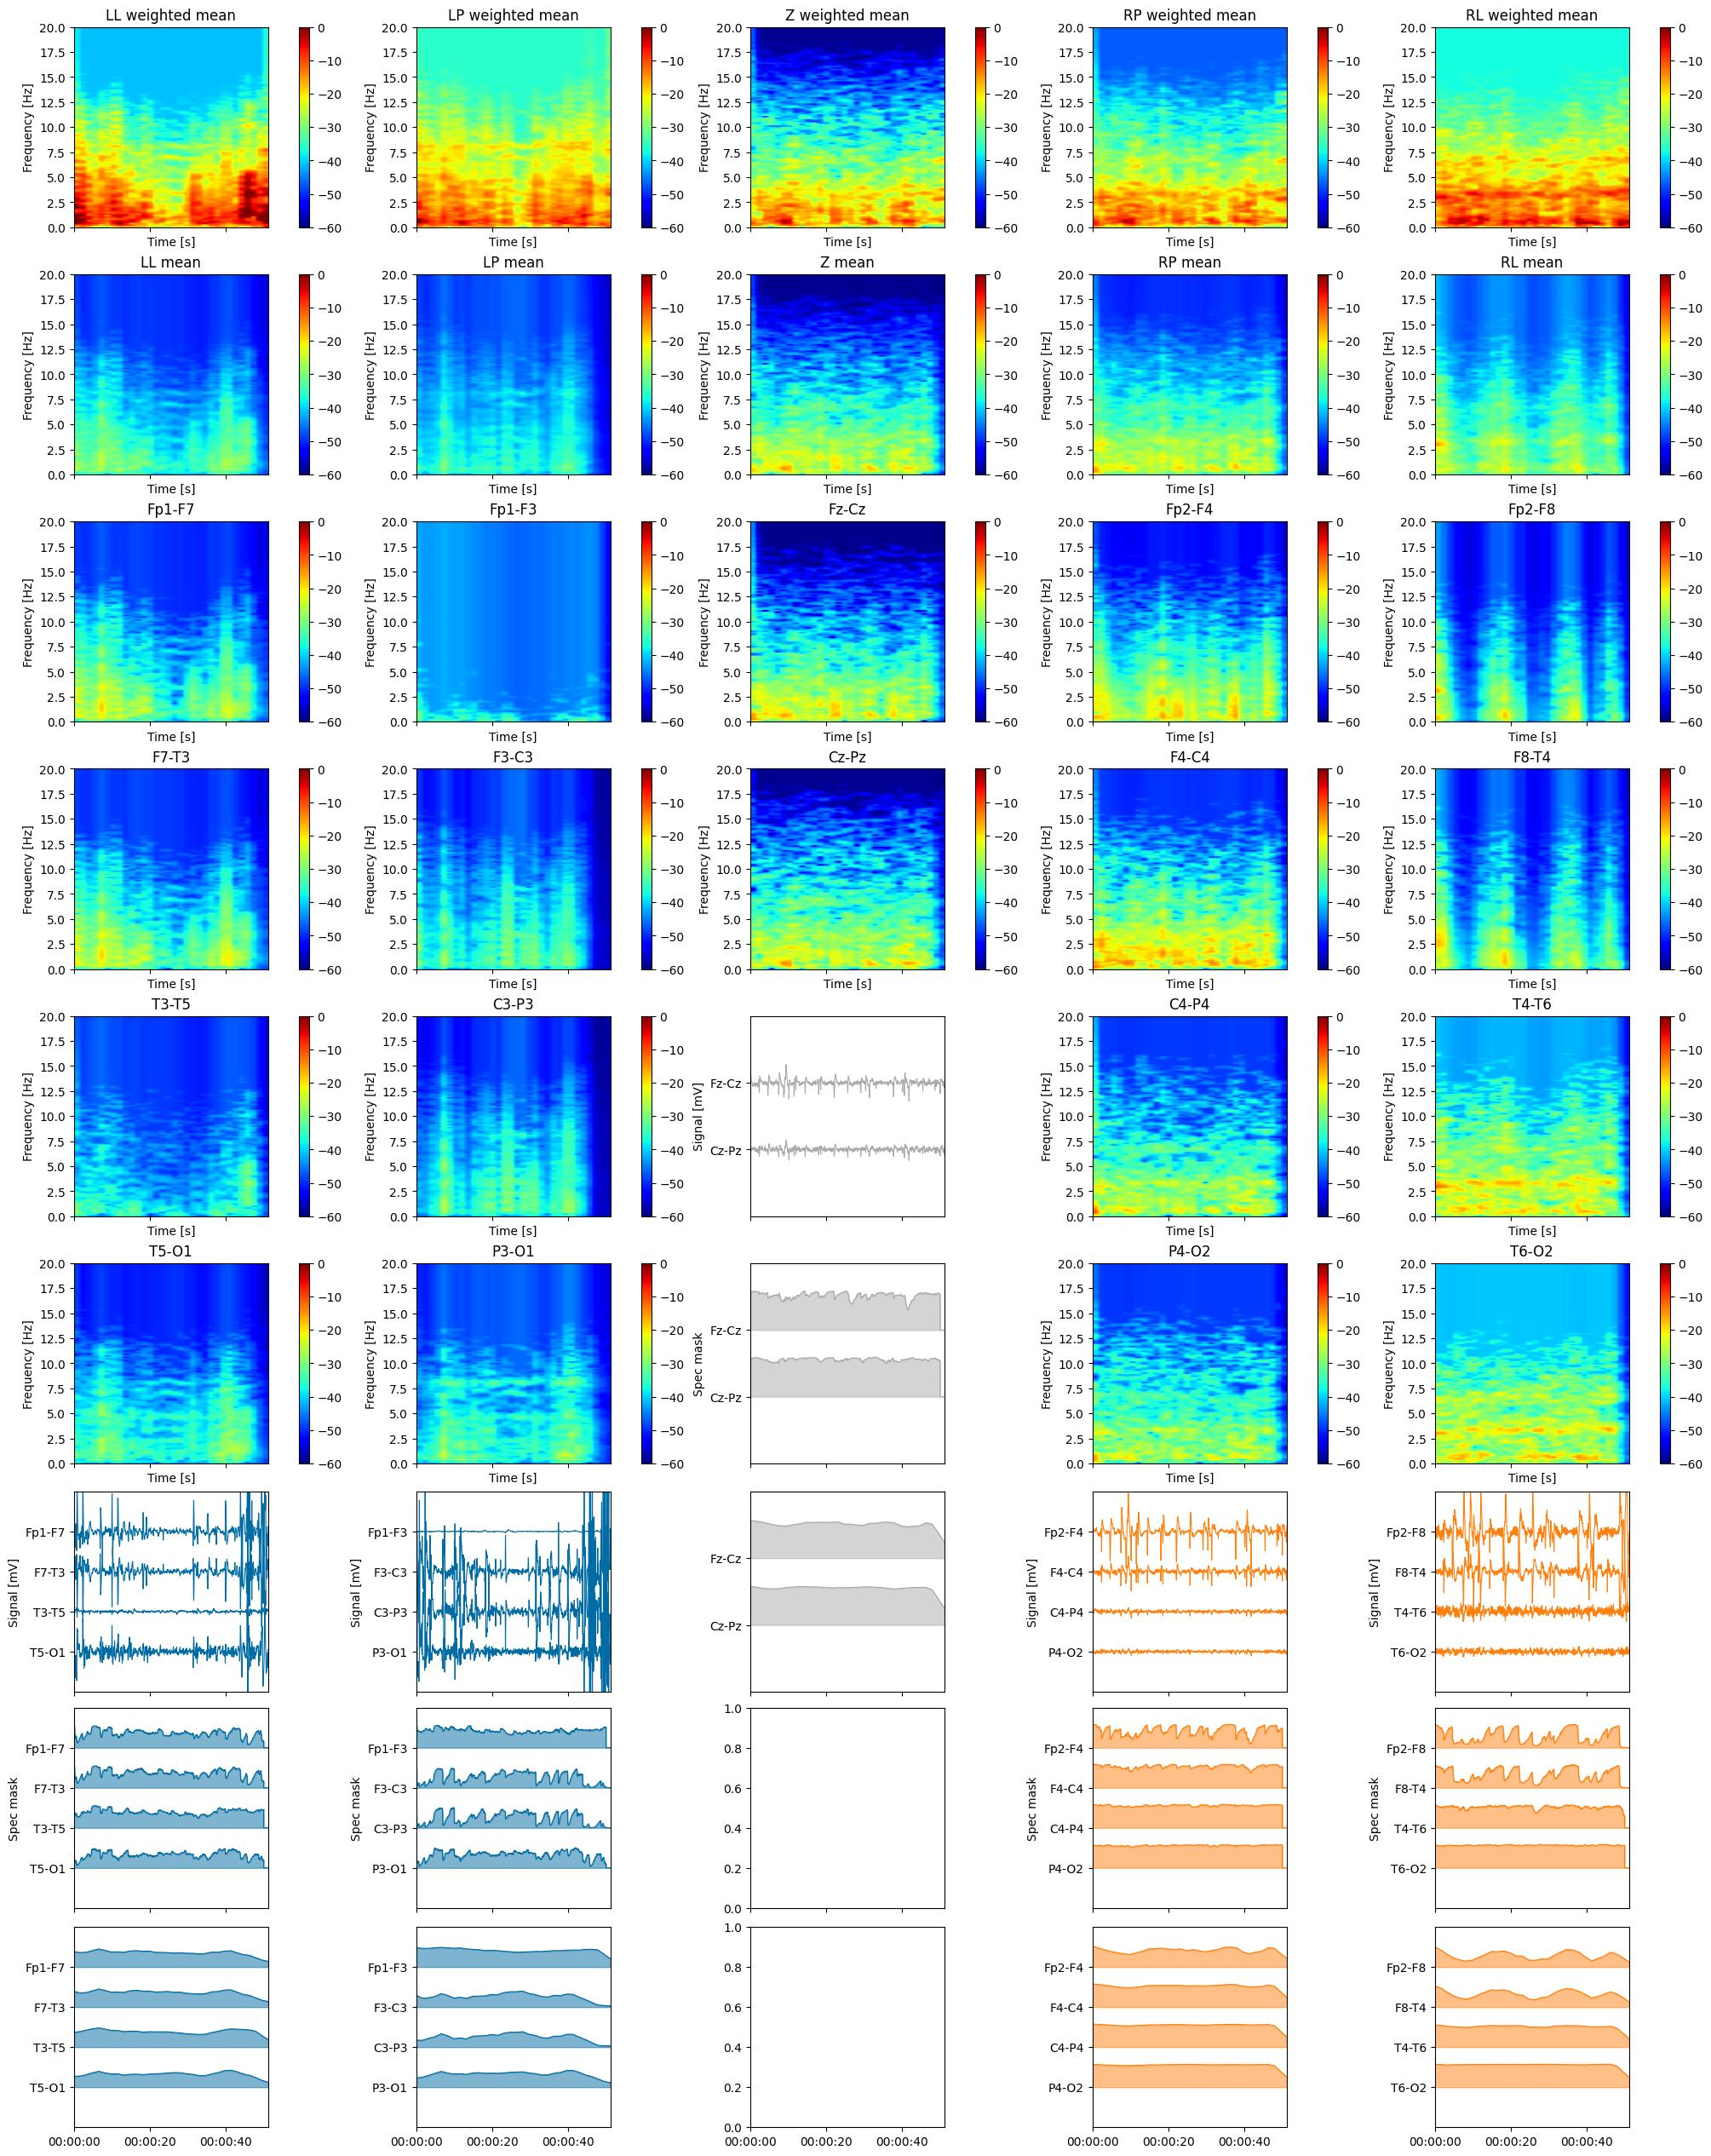

In [71]:
db_cutoff = 60
num_frames = 2048
sampling_rate = 40
frequency_lim = (0, 20)
plot_mask = True
eps = 1e-4

for k in range(num_batches):
    print(eeg_id[k])
    label_tag = ", ".join([f"{k}={v:.2f}" for k, v in zip(LABELS, label[k])])
    print(label_tag)
    num_axis = 8 + 1 if plot_mask else 8
    fig, axes = plt.subplots(
        num_axis,
        5,
        figsize=(20, 2.8 * num_axis),
        sharex=True,
        sharey=False,
        layout="constrained",
    )

    groups = ["LL", "LP", "Z", "RP", "RL"]
    signal_idxs = [0, 4, 8, 10, 14, 18]
    for i, (start, end, group) in enumerate(
        zip(signal_idxs[:-1], signal_idxs[1:], groups)
    ):
        num_signals = end - start
        ax2 = axes[0, i]
        ax4 = axes[1, i]
        axs0 = axes[2 : 2 + num_signals, i]
        ax1 = axes[2 + num_signals, i]

        num_frames = spectrogram.shape[-1]

        extent = (
            0,
            num_frames * hop_length / 40,
            frequency_lim[1],
            frequency_lim[0],
        )

        if group == "LL":
            print("k", k)
            print("spectrogram", spectrogram[k].shape)
            print("signal", signal[k].shape)
            print("chnanel_mask", channel_mask[k].shape)
            print("spec_mask", spec_mask[k].shape)
            print("weight", weight[k].item())

        for j, ax in enumerate(axs0):
            cax = ax.imshow(
                (spectrogram[k, start + j] + db_cutoff) * spec_mask[k, start + j]
                - db_cutoff,
                aspect="auto",
                cmap="jet",
                extent=extent,
                vmin=-db_cutoff,
                vmax=0,
            )
            ax.set(xlabel="Time [s]", ylabel="Frequency [Hz]")
            ax.invert_yaxis()
            ax.set_title("-".join(probe_pairs[start + j]))
            fig.colorbar(cax, ax=ax)

        # mean spectrogram
        mean_spec = (
            (spectrogram[k, start:end] + db_cutoff) * spec_mask[k, start:end]
        ).mean(axis=0) - db_cutoff
        cax = ax4.imshow(
            mean_spec,
            aspect="auto",
            cmap="jet",
            extent=extent,
            vmin=-db_cutoff,
            vmax=0,
        )
        ax4.set(xlabel="Time [s]", ylabel="Frequency [Hz]")
        ax4.invert_yaxis()
        ax4.set_title(f"{group} mean")
        fig.colorbar(cax, ax=ax4)

        # weighted mean spectrogram
        weighted_mean_spec = (
            (spectrogram[k, start:end] + db_cutoff) * spec_mask[k, start:end]
        ).sum(axis=0) / (spec_mask[k, start:end].sum(axis=0) + eps)
        weighted_mean_spec -= db_cutoff
        cax = ax2.imshow(
            weighted_mean_spec,
            aspect="auto",
            cmap="jet",
            extent=extent,
            vmin=-db_cutoff,
            vmax=0,
        )
        ax2.set(xlabel="Time [s]", ylabel="Frequency [Hz]")
        ax2.invert_yaxis()
        ax2.set_title(f"{group} weighted mean")
        fig.colorbar(cax, ax=ax2)

        plot_signal(
            signal[k, start:end],
            probe_pairs[start:end],
            probe_groups[start:end],
            shift=0.2,
            lw=0.8,
            ax=ax1,
        )
        ax1.set(ylabel="Signal [mV]")

        if plot_mask:
            ax3 = axes[2 + num_signals + 1, i]
            plot_signal(
                channel_mask[k, start:end],
                probe_pairs[start:end],
                probe_groups[start:end],
                shift=1.5,
                lw=0.8,
                ax=ax3,
                fill_area=True,
            )
            ax3.set(ylabel="Channel mask")

            ax4 = axes[2 + num_signals + 2, i]
            plot_signal(
                spec_mask[k, start:end, 0],
                probe_pairs[start:end],
                probe_groups[start:end],
                shift=1.5,
                lw=0.8,
                ax=ax4,
                fill_area=True,
                sampling_rate=40 / hop_length,
            )
            ax3.set(ylabel="Spec mask")

    plt.show()

## Findings

- labelごとのdata loadはspectrogramの生成も含めるとかなり遅い（EEGごとに一括生成など工夫が必要）
- CQFによるマスクはspectrogramのノイズ軽減にも効いてそうに見える
- meanをとると像がぼやけるので、チャネルペアごとのspec(c=18)をモデルに直接入力する方が良いかもしれない